In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
from sklearn import metrics

from keras.utils import np_utils
from sklearn.utils import class_weight

2021-08-26 03:47:54.173247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-26 03:47:54.173290: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.__version__, keras.__version__

('2.6.0', '2.6.0')

In [3]:
df = pd.read_csv('all_yrs_processed.csv')
df.head()

,ein,unrelbusinccd,initiationfees,grsrcptspublicuse,grsincmembers,grsincother,totcntrbgfts,totprgmrevnue,invstmntinc,txexmptbndsproceeds,...,nonpfreayr-1_8,nonpfreayr-1_9,nonpfreayr-1_11,nonpfreayr-1_12,nonpfreayr-1_13,nonpfreayr-1_14,nonpfreayr-1_15,y_term,y_liq,y_TL
0,910454080,0,0,0,0,0,935508,120315,7456,19969,...,0,0,0,0,0,0,0,0,0,0
1,111966978,0,0,0,0,0,0,5050020,153784,0,...,0,0,0,0,0,0,0,0,0,0
2,420660491,0,0,0,0,0,2945,11440,489,0,...,0,0,0,0,0,0,0,0,0,0
3,530152390,1,220425,468101,0,0,411058,2668044,29316,0,...,0,0,0,0,0,0,0,0,0,0
4,561547207,0,0,0,0,0,75,735052,783,0,...,0,0,0,0,0,0,0,0,0,0


In [328]:
df.shape

(228181, 545)

In [5]:
df = df.dropna()
print(df.shape)

y_cols = ['y_term', 'y_liq', 'y_TL']
X = df.drop(columns = y_cols).drop(columns = 'ein')
y = df[y_cols]

y1 = y['y_TL'] # y1 - y full/partial 
yt = y['y_term'] # yt - y term (full termination)
yl = y['y_liq']  # yl - y liquid (partial liquidation)

X.shape, y.shape

(228181, 545)


((228181, 541), (228181, 3))

In [348]:
y1.sum() 

3181

In [350]:
y1.sum() / len(y1)

0.01394068743672786

In [6]:
cat_cols = X.nunique()[X.nunique() <=2].index
num_cols = X.nunique()[X.nunique() > 2].index

len(cat_cols), len(num_cols)

(211, 330)

In [7]:
# transfer to log df
numeric_df = X.apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x)
numeric_df = numeric_df.replace(0,1)
numeric_df[np.isfinite(numeric_df)==0]=0
numeric_df.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,unrelbusinccd,initiationfees,grsrcptspublicuse,grsincmembers,grsincother,totcntrbgfts,totprgmrevnue,invstmntinc,txexmptbndsproceeds,royaltsinc,...,nonpfreayr-1_5,nonpfreayr-1_6,nonpfreayr-1_7,nonpfreayr-1_8,nonpfreayr-1_9,nonpfreayr-1_11,nonpfreayr-1_12,nonpfreayr-1_13,nonpfreayr-1_14,nonpfreayr-1_15
1,0.0,0.000000,0.000000,0.0,0.0,0.000000,6.703293,5.186911,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.000000,0.000000,0.0,0.0,6.294340,6.774271,4.483887,0.0,4.683299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.000000,0.000000,0.0,0.0,0.000000,5.529430,1.913814,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1.0,6.051747,5.339859,0.0,0.0,0.000000,6.483899,4.277128,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,1.0,0.000000,0.000000,0.0,0.0,6.930669,6.842122,3.616476,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [279]:
# Train-test split - reg
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.3, random_state = 1) # 70% training and 30% test
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((159726, 541), (68455, 541), (159726,), (68455,))

In [280]:
# Train-test split - log df
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(numeric_df, y1, test_size=0.3,random_state = 1) # 70% training and 30% test
X_train_log.shape, X_test_log.shape, y_train_log.shape, y_test_log.shape

((159726, 541), (68455, 541), (159726,), (68455,))

In [281]:
y_test.sum()

958

In [282]:
# scale data

means = np.mean(np.array(X_train[num_cols]), axis=0, keepdims=True)
stds = np.std(np.array(X_train[num_cols]), axis=0, keepdims=True)

X_train.loc[:,num_cols] = (X_train[num_cols]-means)/stds
X_test.loc[:,num_cols] = (X_test[num_cols]-means)/stds

means_log = np.mean(np.array(X_train_log[num_cols]), axis=0, keepdims=True)
stds_log = np.std(np.array(X_train_log[num_cols]), axis=0, keepdims=True)

X_train_log.loc[:,num_cols] = (X_train_log[num_cols]-means_log)/stds_log
X_test_log.loc[:,num_cols] = (X_test_log[num_cols]-means_log)/stds_log

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [ ]:
# Initialize Results Dictionary
res_dict = {}

# fully connected nn

In [283]:
class FullyConnected():
  """ Fully Connected Network Class """

  def __init__(self, model, X, y, bs, e, X_test,y_test, verbose = 1, cw = None  ):         
    self.model , self.X , self.y , self.bs , self.e , self.X_test, self.y_test, self.verbose, self.cw =  model, X, y, bs, e,X_test, y_test,  verbose, cw
    

  def train(self): 
    # train/validation split
    self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(self.X, self.y, test_size = 0.2) 
    print(self.X_train.shape, self.y_train.shape, self.X_valid.shape, self.X_test.shape)
    
    self.y_train = np_utils.to_categorical(self.y_train)
    self.y_valid = np_utils.to_categorical(self.y_valid)
    
    # fit model
    self.history = self.model.fit(x=self.X_train,
                        y=self.y_train,
                        batch_size=self.bs,
                        epochs=self.e,
                        verbose = self.verbose,
                        validation_data=(self.X_valid, self.y_valid),
                        class_weight = self.cw)
    
    # Training results
    self.results = pd.DataFrame(self.history.history)
    print(self.model.summary())

  def eval(self):
    
    self.y_test2 = np_utils.to_categorical(self.y_test)
    
    # Plot training history 
    self.results.plot()
    plt.title("Errors over time")
    plt.xlabel('Epochs')
    plt.show()
    
    self.evals = self.model.evaluate(self.X_test, self.y_test2)
    

    # Out-of-sample prediction
    
#     return model
    
    
    
    self.y_hat_probs = self.model.predict(self.X_test)
    self.y_hat = np.argmax(self.y_hat_probs,axis=1)
    
    print(self.y_hat.shape)
    print(self.y_test.shape)
    
    print(self.y_hat[:10])
    
    

    
#     self.probability_model = tf.keras.Sequential([model, 
#                                          tf.keras.layers.Softmax()])
#     self.y_hat = self.probability_model.predict(self.X_test)
    
    
    
#     self.accuracy = np.sum(self.y_hat == self.y_test) / len(self.y_hat)

    
#     print(self.y_test[0])
#     print(self.y_hat.max())
#     return self.y_hat
    
    self.cm = confusion_matrix(self.y_test, self.y_hat)
    print(self.cm)
    
    self.tp = self.cm[1][1]
    self.tn = self.cm[0][0]
    self.fp = self.cm[0][1]
    self.fn = self.cm[1][0]
    
    self.fpr, self.tpr, self.thresholds = metrics.roc_curve(self.y_test, self.y_hat)
    self.auc = metrics.auc(self.fpr, self.tpr)
    
#     print(self.auc)
    
    
    return [self.evals[1], self.auc, self.tp, self.tn, self.fp, self.fn]
    
    # Errors
#     self.errs = (self.y_hat - self.y_test)
#     self.errs.plot.hist(bins = np.arange(-4,4,0.5) )
#     plt.title('Distribution of Absolute Errors')
#     plt.show()

#     print(f"Test Accuracy: { self.accuracy.values[0]}  \n Test F1: {self.f1}")
    
#     




In [286]:
y_train.sum()

2223

In [261]:
len(y_train) / y_train.sum()

72.93424657534247

In [287]:
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)

# class_weight = {0: 1.,
#                 1: 50.}

name = '10-15-Adam-relu-cw:1-72'
class_weight = { 0:1, 1:72}

# fit model
learning_rate=0.0001
epochs=30
my_batch_size=300

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation="relu")),
model.add(tf.keras.layers.Dense(units=15, activation="relu")),
# model.add(tf.keras.layers.Dropout(0.5)),
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.AUC()])

In [288]:
mo = FullyConnected(model,X_train, y_train, my_batch_size,epochs, X_test, y_test , cw = class_weight)

In [289]:
mo.train()

(127780, 541) (127780,) (31946, 541) (68455, 541)
Epoch 1/30
426/426 [==============================] - 2s 3ms/step - loss: 1.3989 - auc_51: 0.0610 - val_loss: 0.7417 - val_auc_51: 0.1032
Epoch 2/30
426/426 [==============================] - 1s 3ms/step - loss: 1.3765 - auc_51: 0.1761 - val_loss: 0.7400 - val_auc_51: 0.2134
Epoch 3/30
426/426 [==============================] - 1s 3ms/step - loss: 1.3562 - auc_51: 0.3023 - val_loss: 0.7381 - val_auc_51: 0.3488
Epoch 4/30
426/426 [==============================] - 1s 3ms/step - loss: 1.3350 - auc_51: 0.4471 - val_loss: 0.7244 - val_auc_51: 0.5109
Epoch 5/30
426/426 [==============================] - 1s 3ms/step - loss: 1.3144 - auc_51: 0.5608 - val_loss: 0.7032 - val_auc_51: 0.6223
Epoch 6/30
426/426 [==============================] - 1s 3ms/step - loss: 1.2981 - auc_51: 0.6451 - val_loss: 0.6918 - val_auc_51: 0.6580
Epoch 7/30
426/426 [==============================] - 1s 3ms/step - loss: 1.2861 - auc_51: 0.6843 - val_loss: 0.6796 - val

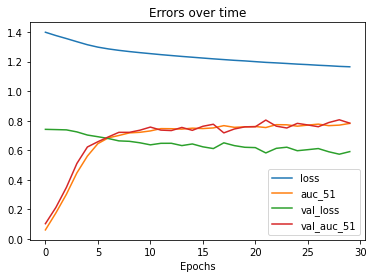

2140/2140 [==============================] - 2s 912us/step - loss: 0.5961 - auc_51: 0.7805
(68455,)
(68455,)
[0 0 0 1 0 0 0 0 0 1]
[[50518 16979]
 [  487   471]]


In [290]:
res_dict[name] = mo.eval()

In [291]:
res_dict

{'10-15-Adam-relu-cw:1-72': [0.7805498838424683,
  0.620048674242477,
  471,
  50518,
  16979,
  487]}

In [305]:
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)

# class_weight = {0: 1.,
#                 1: 50.}

name = '10-15-Adam-relu-cw:1-100'
class_weight = { 0:1, 1:100}

# fit model
learning_rate=0.0001
epochs=30
my_batch_size=300

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation="relu")),
model.add(tf.keras.layers.Dense(units=15, activation="relu")),
# model.add(tf.keras.layers.Dropout(0.5)),
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.AUC(curve = 'ROC')])

In [306]:
mo = FullyConnected(model,X_train, y_train, my_batch_size,epochs, X_test, y_test , cw = class_weight)

In [307]:
mo.train()

(127780, 541) (127780,) (31946, 541) (68455, 541)
Epoch 1/30
426/426 [==============================] - 2s 4ms/step - loss: 1.7373 - auc_55: 0.8990 - val_loss: 0.6800 - val_auc_55: 0.5716
Epoch 2/30
426/426 [==============================] - 1s 3ms/step - loss: 1.6811 - auc_55: 0.2964 - val_loss: 0.7160 - val_auc_55: 0.1412
Epoch 3/30
426/426 [==============================] - 1s 3ms/step - loss: 1.6496 - auc_55: 0.0918 - val_loss: 0.7500 - val_auc_55: 0.0733
Epoch 4/30
426/426 [==============================] - 1s 3ms/step - loss: 1.6186 - auc_55: 0.0717 - val_loss: 0.7730 - val_auc_55: 0.0944
Epoch 5/30
426/426 [==============================] - 1s 3ms/step - loss: 1.5857 - auc_55: 0.1602 - val_loss: 0.7828 - val_auc_55: 0.1878
Epoch 6/30
426/426 [==============================] - 1s 3ms/step - loss: 1.5545 - auc_55: 0.2306 - val_loss: 0.7820 - val_auc_55: 0.2814
Epoch 7/30
426/426 [==============================] - 1s 3ms/step - loss: 1.5311 - auc_55: 0.2995 - val_loss: 0.7911 - val

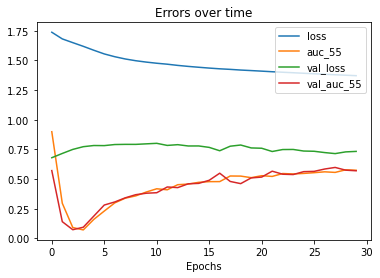

2140/2140 [==============================] - 2s 939us/step - loss: 0.7321 - auc_55: 0.5744
(68455,)
(68455,)
[0 0 1 1 0 1 1 0 0 1]
[[39063 28434]
 [  306   652]]


In [308]:
res_dict[name] = mo.eval()

In [309]:
name = '10-15-Adam-relu-cw:1-150'
class_weight = { 0:1, 1:150}

# fit model
learning_rate=0.0001
epochs=30
my_batch_size=300

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation="relu")),
model.add(tf.keras.layers.Dense(units=15, activation="relu")),
# model.add(tf.keras.layers.Dropout(0.5)),
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.AUC(curve = 'ROC')])

In [310]:
mo = FullyConnected(model,X_train, y_train, my_batch_size,epochs, X_test, y_test , cw = class_weight)

In [311]:
mo.train()

(127780, 541) (127780,) (31946, 541) (68455, 541)
Epoch 1/30
426/426 [==============================] - 2s 4ms/step - loss: 2.0623 - auc_56: 0.1488 - val_loss: 0.8733 - val_auc_56: 0.0262
Epoch 2/30
426/426 [==============================] - 1s 3ms/step - loss: 1.9063 - auc_56: 0.0221 - val_loss: 1.0316 - val_auc_56: 0.0222
Epoch 3/30
426/426 [==============================] - 1s 3ms/step - loss: 1.8590 - auc_56: 0.0218 - val_loss: 1.0591 - val_auc_56: 0.0231
Epoch 4/30
426/426 [==============================] - 1s 3ms/step - loss: 1.8355 - auc_56: 0.0231 - val_loss: 1.0554 - val_auc_56: 0.0245
Epoch 5/30
426/426 [==============================] - 1s 3ms/step - loss: 1.8168 - auc_56: 0.0251 - val_loss: 1.0556 - val_auc_56: 0.0260
Epoch 6/30
426/426 [==============================] - 1s 3ms/step - loss: 1.8004 - auc_56: 0.0279 - val_loss: 1.0479 - val_auc_56: 0.0289
Epoch 7/30
426/426 [==============================] - 1s 3ms/step - loss: 1.7865 - auc_56: 0.0313 - val_loss: 1.0287 - val

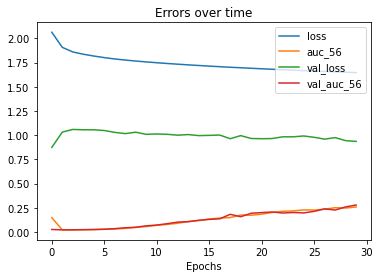

2140/2140 [==============================] - 2s 912us/step - loss: 0.9313 - auc_56: 0.2818
(68455,)
(68455,)
[1 0 1 1 1 1 0 0 0 1]
[[22121 45376]
 [  142   816]]


In [312]:
res_dict[name] = mo.eval()

In [313]:
res_dict

{'10-15-Adam-relu-cw:1-72': [0.7805498838424683,
  0.620048674242477,
  471,
  50518,
  16979,
  487],
 '10-15-Adam-relu-cw:1-150': [0.28176578879356384,
  0.5897538073523905,
  816,
  22121,
  45376,
  142],
 '10-15-Adam-relu-cw:1-100': [0.574372410774231,
  0.6296606919481738,
  652,
  39063,
  28434,
  306]}

In [314]:
name = '10-15-Adam-relu-cw:1-50'
class_weight = { 0:1, 1:50}

# fit model
learning_rate=0.0001
epochs=30
my_batch_size=300

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation="relu")),
model.add(tf.keras.layers.Dense(units=15, activation="relu")),
# model.add(tf.keras.layers.Dropout(0.5)),
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.AUC(curve = 'ROC')])

In [315]:
mo = FullyConnected(model,X_train, y_train, my_batch_size,epochs, X_test, y_test , cw = class_weight)

In [316]:
mo.train()

(127780, 541) (127780,) (31946, 541) (68455, 541)
Epoch 1/30
426/426 [==============================] - 2s 3ms/step - loss: 1.1530 - auc_57: 0.9809 - val_loss: 0.5609 - val_auc_57: 0.9853
Epoch 2/30
426/426 [==============================] - 1s 3ms/step - loss: 1.1184 - auc_57: 0.9856 - val_loss: 0.5253 - val_auc_57: 0.9829
Epoch 3/30
426/426 [==============================] - 1s 3ms/step - loss: 1.0981 - auc_57: 0.9816 - val_loss: 0.5056 - val_auc_57: 0.9767
Epoch 4/30
426/426 [==============================] - 1s 3ms/step - loss: 1.0831 - auc_57: 0.9730 - val_loss: 0.4873 - val_auc_57: 0.9715
Epoch 5/30
426/426 [==============================] - 1s 3ms/step - loss: 1.0703 - auc_57: 0.9654 - val_loss: 0.4847 - val_auc_57: 0.9605
Epoch 6/30
426/426 [==============================] - 1s 3ms/step - loss: 1.0585 - auc_57: 0.9532 - val_loss: 0.4757 - val_auc_57: 0.9550
Epoch 7/30
426/426 [==============================] - 1s 3ms/step - loss: 1.0488 - auc_57: 0.9513 - val_loss: 0.4975 - val

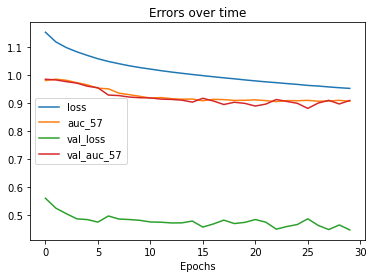

2140/2140 [==============================] - 2s 884us/step - loss: 0.4490 - auc_57: 0.9093
(68455,)
(68455,)
[0 0 1 1 0 1 0 0 0 1]
[[57387 10110]
 [  606   352]]


In [317]:
res_dict[name] = mo.eval()

In [318]:
res_dict

{'10-15-Adam-relu-cw:1-72': [0.7805498838424683,
  0.620048674242477,
  471,
  50518,
  16979,
  487],
 '10-15-Adam-relu-cw:1-150': [0.28176578879356384,
  0.5897538073523905,
  816,
  22121,
  45376,
  142],
 '10-15-Adam-relu-cw:1-100': [0.574372410774231,
  0.6296606919481738,
  652,
  39063,
  28434,
  306],
 '10-15-Adam-relu-cw:1-50': [0.9093009829521179,
  0.6088238577246904,
  352,
  57387,
  10110,
  606]}

In [319]:
name = '10-15-20-15-10-Adam-relu-cw:1-100-dropout.5'
class_weight = { 0:1, 1:100}

# fit model
learning_rate=0.0001
epochs=30
my_batch_size=300

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation="relu")),
model.add(tf.keras.layers.Dense(units=15, activation="relu")),
model.add(tf.keras.layers.Dense(units=20, activation="relu")),
model.add(tf.keras.layers.Dense(units=15, activation="relu")),
model.add(tf.keras.layers.Dense(units=10, activation="relu")),
model.add(tf.keras.layers.Dropout(0.5)),
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.AUC(curve = 'ROC')])

In [320]:
mo = FullyConnected(model,X_train, y_train, my_batch_size,epochs, X_test, y_test , cw = class_weight)

In [321]:
mo.train()

(127780, 541) (127780,) (31946, 541) (68455, 541)
Epoch 1/30
426/426 [==============================] - 2s 4ms/step - loss: 1.6365 - auc_58: 0.0557 - val_loss: 0.7820 - val_auc_58: 0.0184
Epoch 2/30
426/426 [==============================] - 1s 3ms/step - loss: 1.6097 - auc_58: 0.0254 - val_loss: 0.8165 - val_auc_58: 0.0185
Epoch 3/30
426/426 [==============================] - 1s 3ms/step - loss: 1.5863 - auc_58: 0.0272 - val_loss: 0.8230 - val_auc_58: 0.0201
Epoch 4/30
426/426 [==============================] - 1s 3ms/step - loss: 1.5688 - auc_58: 0.0643 - val_loss: 0.8150 - val_auc_58: 0.0650
Epoch 5/30
426/426 [==============================] - 1s 3ms/step - loss: 1.5530 - auc_58: 0.1324 - val_loss: 0.7993 - val_auc_58: 0.1921
Epoch 6/30
426/426 [==============================] - 1s 3ms/step - loss: 1.5515 - auc_58: 0.2461 - val_loss: 0.8118 - val_auc_58: 0.2022
Epoch 7/30
426/426 [==============================] - 1s 3ms/step - loss: 1.5406 - auc_58: 0.2638 - val_loss: 0.7917 - val

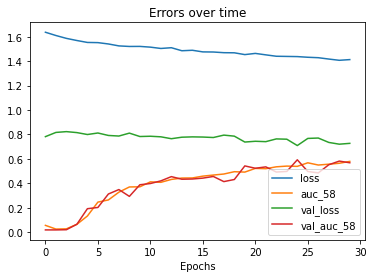

2140/2140 [==============================] - 2s 942us/step - loss: 0.7283 - auc_58: 0.5734
(68455,)
(68455,)
[0 0 1 1 0 1 1 0 0 1]
[[41151 26346]
 [  331   627]]


In [322]:
res_dict[name] = mo.eval()

In [338]:
name = '100-15-20-15-10-Adam-relu-cw:1-100-dropout.5-log_data'
class_weight = { 0:1, 1:100}

# fit model
learning_rate=0.00001
epochs=100
my_batch_size=500

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=100, activation="relu")),
model.add(tf.keras.layers.Dense(units=15, activation="relu")),
model.add(tf.keras.layers.Dense(units=20, activation="relu")),
model.add(tf.keras.layers.Dropout(0.5)),
model.add(tf.keras.layers.Dense(units=15, activation="relu")),
model.add(tf.keras.layers.Dense(units=10, activation="relu")),
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.AUC(curve = 'ROC')])

mo = FullyConnected(model,X_train_log, y_train_log, my_batch_size,epochs, X_test_log, y_test_log , cw = class_weight)

In [339]:
mo.train()

(127780, 541) (127780,) (31946, 541) (68455, 541)
Epoch 1/200
256/256 [==============================] - 2s 5ms/step - loss: 1.6572 - auc_62: 0.0151 - val_loss: 0.7996 - val_auc_62: 0.0149
Epoch 2/200
256/256 [==============================] - 1s 4ms/step - loss: 1.6473 - auc_62: 0.0154 - val_loss: 0.7930 - val_auc_62: 0.0155
Epoch 3/200
256/256 [==============================] - 1s 4ms/step - loss: 1.6353 - auc_62: 0.0160 - val_loss: 0.7890 - val_auc_62: 0.0160
Epoch 4/200
256/256 [==============================] - 1s 4ms/step - loss: 1.6269 - auc_62: 0.0161 - val_loss: 0.7862 - val_auc_62: 0.0165
Epoch 5/200
256/256 [==============================] - 1s 4ms/step - loss: 1.6221 - auc_62: 0.0162 - val_loss: 0.7850 - val_auc_62: 0.0169
Epoch 6/200
256/256 [==============================] - 1s 4ms/step - loss: 1.6110 - auc_62: 0.0167 - val_loss: 0.7855 - val_auc_62: 0.0172
Epoch 7/200
256/256 [==============================] - 1s 4ms/step - loss: 1.6055 - auc_62: 0.0168 - val_loss: 0.787

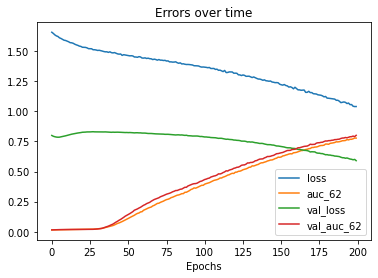

2140/2140 [==============================] - 2s 1ms/step - loss: 0.5923 - auc_62: 0.7969
(68455,)
(68455,)
[0 0 0 1 0 1 0 0 0 0]
[[54492 13005]
 [  532   426]]


In [340]:
res_dict[name] = mo.eval()

In [379]:
name = '10-20-15-Adam-relu-cw:1-72-lr.00001-bs:500'
class_weight = { 0:1, 1:72}

# fit model
learning_rate=0.00001
epochs=100
my_batch_size=500

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation="relu")),
model.add(tf.keras.layers.Dense(units=20, activation="relu")),
model.add(tf.keras.layers.Dense(units=15, activation="relu")),
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.AUC(curve = 'ROC')])

mo = FullyConnected(model,X_train_log, y_train_log, my_batch_size,epochs, X_test_log, y_test_log , cw = class_weight)

In [380]:
mo.train()

(127780, 541) (127780,) (31946, 541) (68455, 541)
Epoch 1/100
256/256 [==============================] - 2s 4ms/step - loss: 1.3215 - auc_70: 0.6895 - val_loss: 0.6224 - val_auc_70: 0.7397
Epoch 2/100
256/256 [==============================] - 1s 3ms/step - loss: 1.2368 - auc_70: 0.7225 - val_loss: 0.6169 - val_auc_70: 0.7359
Epoch 3/100
256/256 [==============================] - 1s 3ms/step - loss: 1.1987 - auc_70: 0.7334 - val_loss: 0.5538 - val_auc_70: 0.7974
Epoch 4/100
256/256 [==============================] - 1s 3ms/step - loss: 1.1680 - auc_70: 0.7569 - val_loss: 0.5966 - val_auc_70: 0.7505
Epoch 5/100
256/256 [==============================] - 1s 3ms/step - loss: 1.1343 - auc_70: 0.7632 - val_loss: 0.5899 - val_auc_70: 0.7539
Epoch 6/100
256/256 [==============================] - 1s 3ms/step - loss: 1.1079 - auc_70: 0.7741 - val_loss: 0.6206 - val_auc_70: 0.7232
Epoch 7/100
256/256 [==============================] - 1s 3ms/step - loss: 1.0739 - auc_70: 0.7825 - val_loss: 0.525

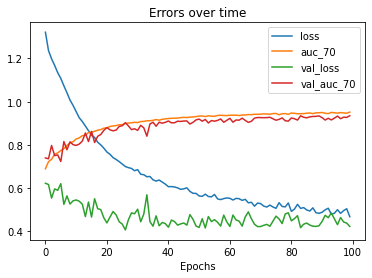

2140/2140 [==============================] - 2s 909us/step - loss: 0.4010 - auc_70: 0.9369
(68455,)
(68455,)
[0 0 0 1 0 0 1 1 0 1]
[[56212 11285]
 [  602   356]]


In [381]:
res_dict[name] = mo.eval()

In [385]:
dfr = pd.DataFrame(res_dict).T
dfr.loc['baseline_RandomForest'] = [0,0.6624175641858729,584,48276,19221,374]
dfr.columns = ['-', 'AUC', 'TP', 'TN', 'FP', 'FN']

dfr['Precision'] = dfr['TP'] / (dfr['TP'] + dfr['FP'])
dfr['Recall'] = dfr['TP'] / (dfr['TP'] + dfr['FN'])

dfr.drop(columns = '-')
# dfr

,AUC,TP,TN,FP,FN,Precision,Recall
10-15-Adam-relu-cw:1-72,0.620049,471.0,50518.0,16979.0,487.0,0.026991,0.491649
10-15-Adam-relu-cw:1-150,0.589754,816.0,22121.0,45376.0,142.0,0.017665,0.851775
10-15-Adam-relu-cw:1-100,0.629661,652.0,39063.0,28434.0,306.0,0.022416,0.680585
10-15-Adam-relu-cw:1-50,0.608824,352.0,57387.0,10110.0,606.0,0.033646,0.367432
10-15-20-15-10-Adam-relu-cw:1-100-dropout.5,0.632080,627.0,41151.0,26346.0,331.0,0.023245,0.654489
10-15-20-15-10-Adam-relu-cw:1-100-dropout.5-log_data,0.645021,572.0,46773.0,20724.0,386.0,0.026860,0.597077
100-15-20-15-10-Adam-relu-cw:1-100-dropout.5-log_data,0.626001,426.0,54492.0,13005.0,532.0,0.031718,0.444676
100-15-20-15-10-Adam-relu-cw:1-100-dropout.5-log_data-l1reg,0.646614,651.0,41422.0,26075.0,307.0,0.024358,0.679541
100-15-20-15-10-Adam-sigmoid-cw:1-100-dropout.5-log_data-l1reg,0.500000,958.0,0.0,67497.0,0.0,0.013995,1.000000
10-20-15-Adam-relu-cw:1-72-lr.00001-bs:500,0.644247,547.0,48430.0,19067.0,411.0,0.027888,0.570981


In [ ]:
pd.DataFrame(np.array([[41422.0,26075.0 ], [307.0, 651.0]]))